In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/svdszvd/automobile.webp
/kaggle/input/cifar10/readme.txt
/kaggle/input/cifar10/cifar10/labels.txt
/kaggle/input/cifar10/cifar10/test/airplane/6221_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/2425_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/6949_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/1705_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/5220_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/3070_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/6304_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/7960_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/3601_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/5367_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/3782_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/313_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/5310_airplane.png
/kaggle/input/cifar10/cifar10/test/airplane/6222_airplane.png
/kaggle/input/cifar10

# Importing Libaries

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from google.colab.patches import cv_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch import nn
from pathlib import Path
from PIL import Image


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Path defining

In [4]:
train_path = "/kaggle/input/cifar10/cifar10/train"
test_path = "/kaggle/input/cifar10/cifar10/test"

In [5]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
class_to_idx={class_name:i for i,class_name in enumerate(class_names)}
print(class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [42]:
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returninng its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(train_path)

There are 10 directories and 0 images in '/kaggle/input/cifar10/cifar10/train'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/airplane'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/horse'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/truck'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/automobile'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/ship'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/dog'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/bird'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/frog'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/cat'
There are 0 directories and 5000 images in '/kaggle/input/cifar10/cifar10/train/deer'


# Custom DataSet



In [7]:
import pathlib
class CIFAR10(Dataset):
    def __init__(self, root_dir, train=True, transform=None, target_transform=None, download=False):
        self.paths = list(pathlib.Path(root_dir).rglob("*.png"))
        self.transform=transform
        self.target_transform=target_transform

    def __len__(self):
        return len(self.paths)

    def load_images(self, index: int):
        image_path=self.paths[index]
        return Image.open(image_path).convert("RGB")

    def __getitem__(self, index: int):
        img = self.load_images(index)  
        class_name = self.paths[index].parent.name
        class_idx = class_to_idx[class_name]
        
        if self.transform:
          img=self.transform(img)
        
        return img, class_idx 

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(14),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Creating Train,Test Datloader


In [9]:
from torch.utils.data import DataLoader
train_dataset = CIFAR10(
        root_dir=train_path,
        train=True,
        transform=train_transform,
        download=True,
    )

test_dataset = CIFAR10(
    root_dir=test_path,
    train=False,
    transform=test_transform,
    download=True,
)

batch_size=64
train_loader=DataLoader(train_dataset,64,shuffle=True,num_workers=2)
test_loader=DataLoader(test_dataset,64,shuffle=False,num_workers=2)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")

Number of samples in train_dataset: 50000
Number of samples in test_dataset: 10000


In [10]:
X_test, y_test = next(iter(test_loader)) 
X_test, y_test = X_test.to(device), y_test.to(device)

img = X_test[15] 
print(len(X_test))
print(len(y_test))
print(f"Real name is {class_names[y_test[15].item()]}")


64
64
Real name is airplane


# CNN Model

In [11]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.Conv2d(hidden_units*4, hidden_units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4, output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)  
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x


input_shape = 3 
hidden_units = 32  
output_shape = 10  

model = CNN(input_shape, hidden_units, output_shape)
import torch.nn.functional as F

# NN


In [12]:
# import torch
# import torch.nn as nn

# class NN(nn.Module):
#     def __init__(self, input_shape, hidden_units, output_shape):
#         super().__init__()
#         self.layer_1 = nn.Linear(input_shape, hidden_units)
#         self.layer_2 = nn.Linear(hidden_units, hidden_units)
#         self.layer_3 = nn.Linear(hidden_units, output_shape)  # FIXED
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # print("Input shape before flatten:", x.shape)
#         x = x.view(x.shape[0], -1) #(batch_size,3,32,32) → (batch_size, 3072)
#         # print("Input shape after flatten:", x.shape)
#         x = self.relu(self.layer_1(x))
#         # print("After layer 1:", x.shape)
#         x = self.relu(self.layer_2(x))
#         # print("After layer 2:",x.shape)
#         x = self.layer_3(x)
#         # print("After layer 3:",x.shape)
#         return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model1 = NN(3 * 32 * 32, 32, 10).to(device)


# Loss and Optimzer Function

In [13]:


loss_fn=nn.CrossEntropyLoss()
# optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [14]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [15]:
def train_step(model:torch.nn.Module,
               data_loader=torch.utils.data.DataLoader,
               loss_fn=loss_fn,
               optimizer=torch.optim.Optimizer,
               accuracy_fn=accuracy_fn,
               device:torch.device=device):

    train_loss = 0
    train_acc = 0
    model.train()

    for batch_idx, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Step [{batch_idx + 1}/{len(data_loader)}], Loss: {loss.item():.4f}")

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.2f}%")


In [16]:
def test_step(model:torch.nn.Module,
               data_loader=torch.utils.data.DataLoader,
               loss_fn=loss_fn,
               optimizer=torch.optim.Optimizer,
               accuracy_fn=accuracy_fn,
               device:torch.device=device):
  test_loss,test_acc=0,0
  model.eval()

  with torch.inference_mode():
    for X_test,y_test in data_loader:

      X_test,y_test=X_test.to(device),y_test.to(device)

      test_pred=model(X_test)

      test_loss+=loss_fn(test_pred,y_test)

      test_acc+=accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

    test_loss/=len(data_loader)

    test_acc/=len(data_loader)

  print(f"Test loss:{test_loss:.5f} | Test acc:{test_acc:.5f}")



# Trainning and testing for NN


In [17]:
# torch.manual_seed(42)
# from tqdm import tqdm
# from timeit import default_timer as timer
# train_time_start_on_gpu = timer()

# epochs = 10

# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch} -------")
    

#     model = model1.to(device)

#     train_step(model=model1.to(device),
#                data_loader=train_loader,
#                loss_fn=loss_fn,
#                optimizer=optimizer,
#                accuracy_fn=accuracy_fn,
#                device=device)

#     test_step(model=model1.to(device),
#               data_loader=test_loader,
#               loss_fn=loss_fn,
#               accuracy_fn=accuracy_fn,
#               device=device)
#     scheduler.step()
    
# train_time_end_on_gpu=timer()
# print(f"Total time spend on GPU:{train_time_end_on_gpu-train_time_start_on_gpu}")

# Trainning and Testing for CNN


In [18]:
torch.manual_seed(42)
from tqdm import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 25

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} -------")
    

    model = model.to(device)

    train_step(model=model.to(device),
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model.to(device),
              data_loader=test_loader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    scheduler.step()

train_time_end_on_gpu=timer()
print(f"Total time spend on GPU:{train_time_end_on_gpu-train_time_start_on_gpu}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 -------
Step [100/782], Loss: 1.3604
Step [200/782], Loss: 1.3821
Step [300/782], Loss: 1.4239
Step [400/782], Loss: 1.2101
Step [500/782], Loss: 1.2508
Step [600/782], Loss: 1.1986
Step [700/782], Loss: 1.1655
Train Loss: 1.30805, Train Accuracy: 52.57%


  4%|▍         | 1/25 [00:54<21:36, 54.04s/it]

Test loss:2.16438 | Test acc:34.61385
Epoch: 1 -------
Step [100/782], Loss: 1.1962
Step [200/782], Loss: 1.2352
Step [300/782], Loss: 0.7890
Step [400/782], Loss: 1.2349
Step [500/782], Loss: 0.8567
Step [600/782], Loss: 1.3227
Step [700/782], Loss: 0.9118
Train Loss: 0.93271, Train Accuracy: 67.06%


  8%|▊         | 2/25 [01:47<20:34, 53.68s/it]

Test loss:2.03957 | Test acc:38.55494
Epoch: 2 -------
Step [100/782], Loss: 0.9180
Step [200/782], Loss: 0.6523
Step [300/782], Loss: 1.0659
Step [400/782], Loss: 0.6549
Step [500/782], Loss: 0.6725
Step [600/782], Loss: 0.6796
Step [700/782], Loss: 0.8890
Train Loss: 0.77432, Train Accuracy: 72.84%


 12%|█▏        | 3/25 [02:40<19:37, 53.54s/it]

Test loss:1.91361 | Test acc:41.26194
Epoch: 3 -------
Step [100/782], Loss: 0.7586
Step [200/782], Loss: 0.9128
Step [300/782], Loss: 0.6904
Step [400/782], Loss: 0.5707
Step [500/782], Loss: 0.7336
Step [600/782], Loss: 0.4928
Step [700/782], Loss: 0.7137
Train Loss: 0.68807, Train Accuracy: 75.87%


 16%|█▌        | 4/25 [03:32<18:27, 52.72s/it]

Test loss:1.20670 | Test acc:57.94188
Epoch: 4 -------
Step [100/782], Loss: 0.7505
Step [200/782], Loss: 0.5781
Step [300/782], Loss: 0.7203
Step [400/782], Loss: 0.4445
Step [500/782], Loss: 0.5224
Step [600/782], Loss: 0.4354
Step [700/782], Loss: 0.6095
Train Loss: 0.62105, Train Accuracy: 78.44%


 20%|██        | 5/25 [04:24<17:29, 52.46s/it]

Test loss:1.34164 | Test acc:55.91162
Epoch: 5 -------
Step [100/782], Loss: 0.4522
Step [200/782], Loss: 0.4982
Step [300/782], Loss: 0.7942
Step [400/782], Loss: 0.9046
Step [500/782], Loss: 0.5421
Step [600/782], Loss: 0.4863
Step [700/782], Loss: 0.4512
Train Loss: 0.57438, Train Accuracy: 80.21%


 24%|██▍       | 6/25 [05:16<16:34, 52.35s/it]

Test loss:1.07542 | Test acc:63.00756
Epoch: 6 -------
Step [100/782], Loss: 0.5868
Step [200/782], Loss: 0.6089
Step [300/782], Loss: 0.5929
Step [400/782], Loss: 0.6242
Step [500/782], Loss: 0.4625
Step [600/782], Loss: 0.3279
Step [700/782], Loss: 0.3931
Train Loss: 0.53539, Train Accuracy: 81.47%


 28%|██▊       | 7/25 [06:08<15:37, 52.10s/it]

Test loss:0.95022 | Test acc:67.09793
Epoch: 7 -------
Step [100/782], Loss: 0.2672
Step [200/782], Loss: 0.3286
Step [300/782], Loss: 0.4665
Step [400/782], Loss: 0.4624
Step [500/782], Loss: 0.3563
Step [600/782], Loss: 0.3865
Step [700/782], Loss: 0.2845
Train Loss: 0.42336, Train Accuracy: 85.57%


 32%|███▏      | 8/25 [07:00<14:47, 52.18s/it]

Test loss:0.84672 | Test acc:71.71576
Epoch: 8 -------
Step [100/782], Loss: 0.3824
Step [200/782], Loss: 0.4433
Step [300/782], Loss: 0.4017
Step [400/782], Loss: 0.2670
Step [500/782], Loss: 0.3545
Step [600/782], Loss: 0.3552
Step [700/782], Loss: 0.4741
Train Loss: 0.39469, Train Accuracy: 86.44%


 36%|███▌      | 9/25 [07:53<13:58, 52.40s/it]

Test loss:0.78270 | Test acc:73.85549
Epoch: 9 -------
Step [100/782], Loss: 0.4145
Step [200/782], Loss: 0.6237
Step [300/782], Loss: 0.4015
Step [400/782], Loss: 0.2893
Step [500/782], Loss: 0.3388
Step [600/782], Loss: 0.4815
Step [700/782], Loss: 0.3605
Train Loss: 0.38386, Train Accuracy: 87.07%


 40%|████      | 10/25 [08:45<13:06, 52.44s/it]

Test loss:0.79447 | Test acc:73.02946
Epoch: 10 -------
Step [100/782], Loss: 0.2589
Step [200/782], Loss: 0.3552
Step [300/782], Loss: 0.4228
Step [400/782], Loss: 0.3923
Step [500/782], Loss: 0.4650
Step [600/782], Loss: 0.5405
Step [700/782], Loss: 0.5674
Train Loss: 0.37408, Train Accuracy: 87.17%


 44%|████▍     | 11/25 [09:38<12:14, 52.43s/it]

Test loss:0.80645 | Test acc:73.13893
Epoch: 11 -------
Step [100/782], Loss: 0.4255
Step [200/782], Loss: 0.3952
Step [300/782], Loss: 0.6806
Step [400/782], Loss: 0.3767
Step [500/782], Loss: 0.2963
Step [600/782], Loss: 0.2832
Step [700/782], Loss: 0.5466
Train Loss: 0.36478, Train Accuracy: 87.51%


 48%|████▊     | 12/25 [10:31<11:23, 52.57s/it]

Test loss:0.84295 | Test acc:71.45701
Epoch: 12 -------
Step [100/782], Loss: 0.3934
Step [200/782], Loss: 0.4967
Step [300/782], Loss: 0.3784
Step [400/782], Loss: 0.4286
Step [500/782], Loss: 0.4195
Step [600/782], Loss: 0.3058
Step [700/782], Loss: 0.4000
Train Loss: 0.35812, Train Accuracy: 87.69%


 52%|█████▏    | 13/25 [11:23<10:31, 52.65s/it]

Test loss:0.79880 | Test acc:73.09912
Epoch: 13 -------
Step [100/782], Loss: 0.2869
Step [200/782], Loss: 0.2104
Step [300/782], Loss: 0.5490
Step [400/782], Loss: 0.3510
Step [500/782], Loss: 0.4909
Step [600/782], Loss: 0.2058
Step [700/782], Loss: 0.2999
Train Loss: 0.34726, Train Accuracy: 88.18%


 56%|█████▌    | 14/25 [12:16<09:38, 52.58s/it]

Test loss:0.74004 | Test acc:74.93033
Epoch: 14 -------
Step [100/782], Loss: 0.2234
Step [200/782], Loss: 0.1630
Step [300/782], Loss: 0.3011
Step [400/782], Loss: 0.4382
Step [500/782], Loss: 0.4150
Step [600/782], Loss: 0.3490
Step [700/782], Loss: 0.4414
Train Loss: 0.33365, Train Accuracy: 88.77%


 60%|██████    | 15/25 [13:08<08:43, 52.32s/it]

Test loss:0.75810 | Test acc:74.36306
Epoch: 15 -------
Step [100/782], Loss: 0.4312
Step [200/782], Loss: 0.3849
Step [300/782], Loss: 0.3900
Step [400/782], Loss: 0.3303
Step [500/782], Loss: 0.3178
Step [600/782], Loss: 0.4995
Step [700/782], Loss: 0.3466
Train Loss: 0.33343, Train Accuracy: 88.70%


 64%|██████▍   | 16/25 [13:59<07:49, 52.14s/it]

Test loss:0.73987 | Test acc:75.29857
Epoch: 16 -------
Step [100/782], Loss: 0.4020
Step [200/782], Loss: 0.2368
Step [300/782], Loss: 0.2704
Step [400/782], Loss: 0.5024
Step [500/782], Loss: 0.2453
Step [600/782], Loss: 0.3114
Step [700/782], Loss: 0.3176
Train Loss: 0.33396, Train Accuracy: 88.68%


 68%|██████▊   | 17/25 [14:54<07:03, 52.98s/it]

Test loss:0.78859 | Test acc:73.99482
Epoch: 17 -------
Step [100/782], Loss: 0.3241
Step [200/782], Loss: 0.3049
Step [300/782], Loss: 0.2924
Step [400/782], Loss: 0.2847
Step [500/782], Loss: 0.3053
Step [600/782], Loss: 0.3009
Step [700/782], Loss: 0.3427
Train Loss: 0.32938, Train Accuracy: 88.87%


 72%|███████▏  | 18/25 [15:50<06:16, 53.74s/it]

Test loss:0.75900 | Test acc:74.41282
Epoch: 18 -------
Step [100/782], Loss: 0.3106
Step [200/782], Loss: 0.2559
Step [300/782], Loss: 0.1799
Step [400/782], Loss: 0.4321
Step [500/782], Loss: 0.2627
Step [600/782], Loss: 0.2879
Step [700/782], Loss: 0.3720
Train Loss: 0.32962, Train Accuracy: 88.74%


 76%|███████▌  | 19/25 [16:43<05:22, 53.67s/it]

Test loss:0.71927 | Test acc:75.94546
Epoch: 19 -------
Step [100/782], Loss: 0.4200
Step [200/782], Loss: 0.4465
Step [300/782], Loss: 0.2707
Step [400/782], Loss: 0.3687
Step [500/782], Loss: 0.3592
Step [600/782], Loss: 0.2269
Step [700/782], Loss: 0.2683
Train Loss: 0.32602, Train Accuracy: 89.02%


 80%|████████  | 20/25 [17:36<04:27, 53.50s/it]

Test loss:0.75785 | Test acc:74.29339
Epoch: 20 -------
Step [100/782], Loss: 0.2994
Step [200/782], Loss: 0.3656
Step [300/782], Loss: 0.2506
Step [400/782], Loss: 0.3353
Step [500/782], Loss: 0.3014
Step [600/782], Loss: 0.2462
Step [700/782], Loss: 0.3772
Train Loss: 0.32669, Train Accuracy: 88.81%


 84%|████████▍ | 21/25 [18:28<03:31, 52.90s/it]

Test loss:0.76896 | Test acc:74.46258
Epoch: 21 -------
Step [100/782], Loss: 0.2972
Step [200/782], Loss: 0.2340
Step [300/782], Loss: 0.3363
Step [400/782], Loss: 0.2592
Step [500/782], Loss: 0.3650
Step [600/782], Loss: 0.2559
Step [700/782], Loss: 0.4176
Train Loss: 0.32569, Train Accuracy: 88.84%


 88%|████████▊ | 22/25 [19:19<02:36, 52.29s/it]

Test loss:0.72798 | Test acc:75.51752
Epoch: 22 -------
Step [100/782], Loss: 0.3439
Step [200/782], Loss: 0.3096
Step [300/782], Loss: 0.3659
Step [400/782], Loss: 0.3098
Step [500/782], Loss: 0.2904
Step [600/782], Loss: 0.3907
Step [700/782], Loss: 0.2808
Train Loss: 0.32391, Train Accuracy: 89.04%


 92%|█████████▏| 23/25 [20:09<01:43, 51.82s/it]

Test loss:0.76866 | Test acc:74.24363
Epoch: 23 -------
Step [100/782], Loss: 0.3371
Step [200/782], Loss: 0.4786
Step [300/782], Loss: 0.1901
Step [400/782], Loss: 0.3823
Step [500/782], Loss: 0.2191
Step [600/782], Loss: 0.2650
Step [700/782], Loss: 0.4061
Train Loss: 0.32532, Train Accuracy: 88.90%


 96%|█████████▌| 24/25 [21:01<00:51, 51.62s/it]

Test loss:0.75701 | Test acc:74.91043
Epoch: 24 -------
Step [100/782], Loss: 0.5269
Step [200/782], Loss: 0.2795
Step [300/782], Loss: 0.3682
Step [400/782], Loss: 0.4146
Step [500/782], Loss: 0.3045
Step [600/782], Loss: 0.3383
Step [700/782], Loss: 0.2202
Train Loss: 0.32316, Train Accuracy: 88.94%


100%|██████████| 25/25 [21:53<00:00, 52.53s/it]

Test loss:0.73378 | Test acc:75.54737
Total time spend on GPU:1313.2704251599998


In [19]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn,
               device: torch.device):
    loss, acc = 0, 0

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y).item()

            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss,
    }
    


In [20]:

model_results=eval_model(model=model.to(device),
                           data_loader=test_loader,
                           loss_fn=loss_fn,
                           device=device)
model_results

# model1_results=eval_model(model=model1.to(device),
#                            data_loader=test_loader,
#                            loss_fn=loss_fn,
#                            device=device)
# model1_results

{'model_name': 'CNN', 'model_loss': 0.7337794381721764}

In [21]:
print()

In [38]:

def predict(model, image_path, device, class_names):
 
    model.eval()  
    image = Image.open(image_path).convert("RGB")
    
    transform = transforms.Compose([
        transforms.Resize((32, 32)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)  

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class_index = torch.argmax(probabilities, dim=1).item()

    predicted_class_label = class_names[predicted_class_index]

        
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis("off")
    plt.show()

    return predicted_class_label




In [39]:
def calculate_accuracy(model, test_loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels = images.to(device),labels.to(device)
            outputs=model(images)
            
            probs=torch.softmax(outputs,dim=1)
            predicted=torch.argmax(probs,dim=1) 
            
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()

    accuracy = 100*correct/total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy

calculate_accuracy(model,test_loader,device)

Accuracy of the model on the test images: 75.52%


75.52

# Sample Test case

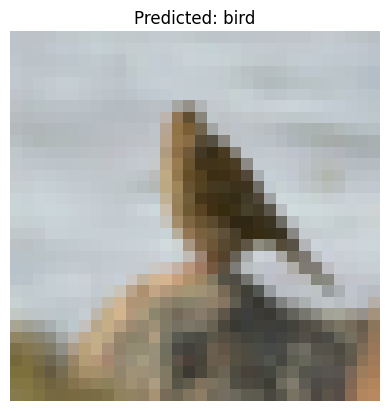

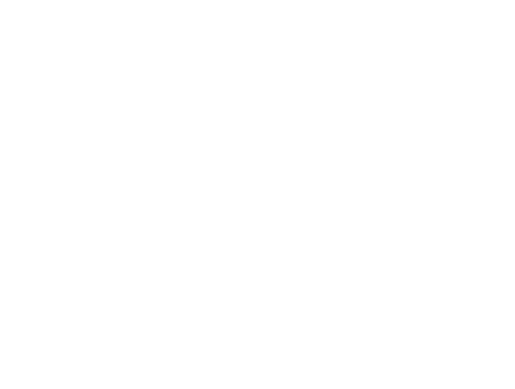

In [40]:
image_path = "/kaggle/input/cifar10/cifar10/test/bird/1038_bird.png" 
predicted_label = predict(model, image_path, device, class_names)
plt.axis('off')  
plt.show()


# Testing on Random Image


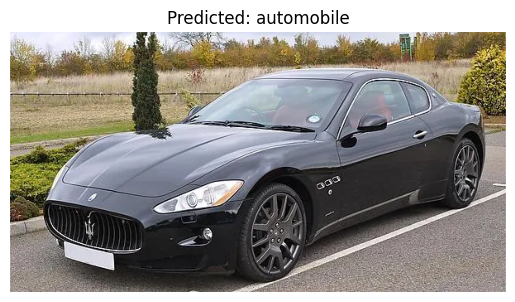

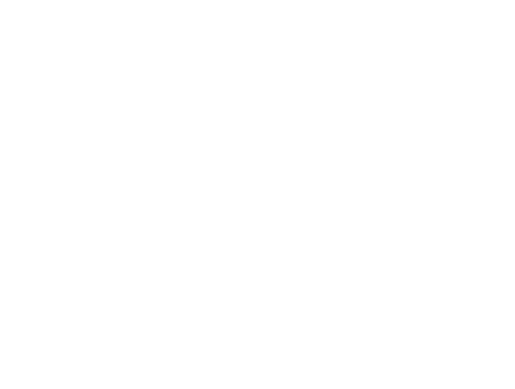

In [41]:
image_path = "/kaggle/input/svdszvd/automobile.webp" 
image = Image.open(image_path)
predicted_label = predict(model, image_path, device, class_names)
plt.axis('off')  

plt.show()

